Titanic Survivor Model, v1
Mickey Whittaker
6/11/25

Read CSV data

In [32]:
import pandas as pd

train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Drop Name and Ticket columns, not valuable to my understanding

In [33]:
cleaning = train.drop(['Name','Ticket'], axis=1)

Replace Sex with binary is_male 1 (yes) or female (0)

In [34]:
cleaning['is_male'] = cleaning['Sex'].replace({'male':1, 'female': 0})
cleaning.head()

C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_42868\1071466452.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaning['is_male'] = cleaning['Sex'].replace({'male':1, 'female': 0})


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,is_male
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,1
1,2,1,1,female,38.0,1,0,71.2833,C85,C,0
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,0
3,4,1,1,female,35.0,1,0,53.1000,C123,S,0
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,1


drop old 'Sex' column

In [35]:
cleaning.drop('Sex', axis=1, inplace=True)
print(cleaning.head())

   PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare Cabin Embarked  \
0            1         0       3  22.0      1      0   7.2500   NaN        S   
1            2         1       1  38.0      1      0  71.2833   C85        C   
2            3         1       3  26.0      0      0   7.9250   NaN        S   
3            4         1       1  35.0      1      0  53.1000  C123        S   
4            5         0       3  35.0      0      0   8.0500   NaN        S   

   is_male  
0        1  
1        0  
2        0  
3        0  
4        1  


drop missing age rows from training model

In [36]:
cleaning['Age'] = cleaning['Age'].fillna(0)
cleaning = cleaning[cleaning['Age'] !=0]

In [37]:
cleaning['norm_age'] = (cleaning['Age'] - cleaning['Age'].min()) / (cleaning['Age'].max() - cleaning['Age'].min())
cleaning.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,is_male,norm_age
0,1,0,3,22.0,1,0,7.2500,NaN,S,1,0.271174
1,2,1,1,38.0,1,0,71.2833,C85,C,0,0.472229
2,3,1,3,26.0,0,0,7.9250,NaN,S,0,0.321438
3,4,1,1,35.0,1,0,53.1000,C123,S,0,0.434531
4,5,0,3,35.0,0,0,8.0500,NaN,S,1,0.434531


In [38]:
cleaning.drop('Age', axis=1, inplace=True)
cleaning.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Cabin,Embarked,is_male,norm_age
0,1,0,3,1,0,7.2500,NaN,S,1,0.271174
1,2,1,1,1,0,71.2833,C85,C,0,0.472229
2,3,1,3,0,0,7.9250,NaN,S,0,0.321438
3,4,1,1,1,0,53.1000,C123,S,0,0.434531
4,5,0,3,0,0,8.0500,NaN,S,1,0.434531


In [39]:
cleaning['emb_s'] = (cleaning['Embarked'] == 'S').astype(int)
cleaning['emb_c'] = (cleaning['Embarked'] == 'C').astype(int)
cleaning.head()


,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Cabin,Embarked,is_male,norm_age,emb_s,emb_c
0,1,0,3,1,0,7.2500,NaN,S,1,0.271174,1,0
1,2,1,1,1,0,71.2833,C85,C,0,0.472229,0,1
2,3,1,3,0,0,7.9250,NaN,S,0,0.321438,1,0
3,4,1,1,1,0,53.1000,C123,S,0,0.434531,1,0
4,5,0,3,0,0,8.0500,NaN,S,1,0.434531,1,0


In [40]:
cleaning.drop('Embarked', axis=1, inplace=True)

In [41]:
cleaning = pd.concat([cleaning, pd.get_dummies(cleaning['Pclass'], prefix='Pclass')], axis=1)
cleaning.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Cabin,is_male,norm_age,emb_s,emb_c,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,1,0,7.2500,NaN,1,0.271174,1,0,False,False,True
1,2,1,1,1,0,71.2833,C85,0,0.472229,0,1,True,False,False
2,3,1,3,0,0,7.9250,NaN,0,0.321438,1,0,False,False,True
3,4,1,1,1,0,53.1000,C123,0,0.434531,1,0,True,False,False
4,5,0,3,0,0,8.0500,NaN,1,0.434531,1,0,False,False,True


Oops, need ints...

In [42]:
for col in ['Pclass_1','Pclass_2','Pclass_3']:
    cleaning[col] = cleaning[col].astype(int)

drop old pclass, and extra pclass_3 columns

In [ ]:
cleaning = cleaning.drop(['Pclass'], axis=1)
cleaning = cleaning.drop(['Pclass_3'], axis=1)  
cleaning.head()

,PassengerId,Survived,SibSp,Parch,Fare,Cabin,is_male,norm_age,emb_s,emb_c,Pclass_1,Pclass_2
0,1,0,1,0,7.2500,NaN,1,0.271174,1,0,0,0
1,2,1,1,0,71.2833,C85,0,0.472229,0,1,1,0
2,3,1,0,0,7.9250,NaN,0,0.321438,1,0,0,0
3,4,1,1,0,53.1000,C123,0,0.434531,1,0,1,0
4,5,0,0,0,8.0500,NaN,1,0.434531,1,0,0,0


In [46]:
cleaning.to_csv('cleaned_train.csv', index=False)

In [47]:
test_female = cleaning[cleaning['is_male'] == 0]
print(f"female survival rate= {test_female['Survived'].mean() * 100:.2f}%")

female survival rate= 75.48%


In [50]:
pc_1 = cleaning[cleaning['Pclass_1'] == 1]
pc_2 = cleaning[cleaning['Pclass_2'] == 1]
pc_3 = cleaning[
    (cleaning['Pclass_2'] == 0) & (cleaning['Pclass_1'] == 0)
    ]
print(f"pclass 1 survival rate= {pc_1['Survived'].mean() * 100:.2f}%")
print(f"pclass 2 survival rate= {pc_2['Survived'].mean() * 100:.2f}%")
print(f"pclass 3 survival rate= {pc_3['Survived'].mean() * 100:.2f}%")

pclass 1 survival rate= 65.59%
pclass 2 survival rate= 47.98%
pclass 3 survival rate= 23.94%


In [53]:
m_pc_1 = pc_1['Fare'].mean()
m_pc_2 = pc_2['Fare'].mean()
m_pc_3 = pc_3['Fare'].mean()
print(f"pclass 1 mean fare= {m_pc_1:.2f}")
print(f"pclass 2 mean fare= {m_pc_2:.2f}")
print(f"pclass 3 mean fare= {m_pc_3:.2f}")

pclass 1 mean fare= 87.96
pclass 2 mean fare= 21.47
pclass 3 mean fare= 13.23


In [55]:
f_m_pc_1 = cleaning[(cleaning['Pclass_1'] == 1) & (cleaning['is_male'] == 0)]['Fare'].mean()
f_m_pc_2 = cleaning[(cleaning['Pclass_2'] == 1) & (cleaning['is_male'] == 0)]['Fare'].mean()
f_m_pc_3 = cleaning[
    (cleaning['Pclass_2'] == 0) & (cleaning['Pclass_1'] == 0) & (cleaning['is_male'] == 0)
    ]['Fare'].mean()

print(f"female pclass 1 mean fare= {f_m_pc_1:.2f}")
print(f"female pclass 2 mean fare= {f_m_pc_2:.2f}")
print(f"female pclass 3 mean fare= {f_m_pc_3:.2f}")

female pclass 1 mean fare= 107.95
female pclass 2 mean fare= 21.95
female pclass 3 mean fare= 15.88


In [57]:
f_pc_1 = cleaning[
    (cleaning['Pclass_1'] == 1) & (cleaning['is_male'] == 0)
    ]
f_pc_2 = cleaning[
    (cleaning['Pclass_2'] == 1) & (cleaning['is_male'] == 0)
    ]
f_pc_3 = cleaning[
    (cleaning['Pclass_2'] == 0) & (cleaning['Pclass_1'] == 0) & (cleaning['is_male'] == 0)
    ]
print(f"females of pclass 1 survival rate= {f_pc_1['Survived'].mean() * 100:.2f}%\n")
print(f"females of pclass 2 survival rate= {f_pc_2['Survived'].mean() * 100:.2f}%\n")
print(f"females of pclass 3 survival rate= {f_pc_3['Survived'].mean() * 100:.2f}%\n")

f_pc_1_fare = f_pc_1['Fare'].quantile([.10, 0.25, 0.5, 0.75, .90])
f_pc_2_fare = f_pc_2['Fare'].quantile([.10, 0.25, 0.5, 0.75, .90])
f_pc_3_fare = f_pc_3['Fare'].quantile([.10, 0.25, 0.5, 0.75, .90])
print(f"females of pclass 1 fare quantiles:\n{f_pc_1_fare}\n")
print(f"females of pclass 2 fare quantiles:\n{f_pc_2_fare}\n")
print(f"females of pclass 3 fare quantiles:\n{f_pc_3_fare}\n")

females of pclass 1 survival rate= 96.47%

females of pclass 2 survival rate= 91.89%

females of pclass 3 survival rate= 46.08%

females of pclass 1 fare quantiles:
0.10     39.4800
0.25     57.9792
0.50     83.1583
0.75    135.6333
0.90    221.0500
Name: Fare, dtype: float64

females of pclass 2 fare quantiles:
0.10    10.95000
0.25    13.00000
0.50    22.00000
0.75    26.00000
0.90    31.77124
Name: Fare, dtype: float64

females of pclass 3 fare quantiles:
0.10     7.75000
0.25     7.92500
0.50    12.94585
0.75    19.97395
0.90    31.27500
Name: Fare, dtype: float64



In [51]:
qs = cleaning['Fare'].quantile([.10, 0.25, 0.5, 0.75, .90])
print(f"Fare quantiles:\n{qs}")

Fare quantiles:
0.10     7.7500
0.25     8.0500
0.50    15.7417
0.75    33.3750
0.90    79.5150
Name: Fare, dtype: float64


C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_42868\323232438.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Pclass', 'decile'])['Survived']


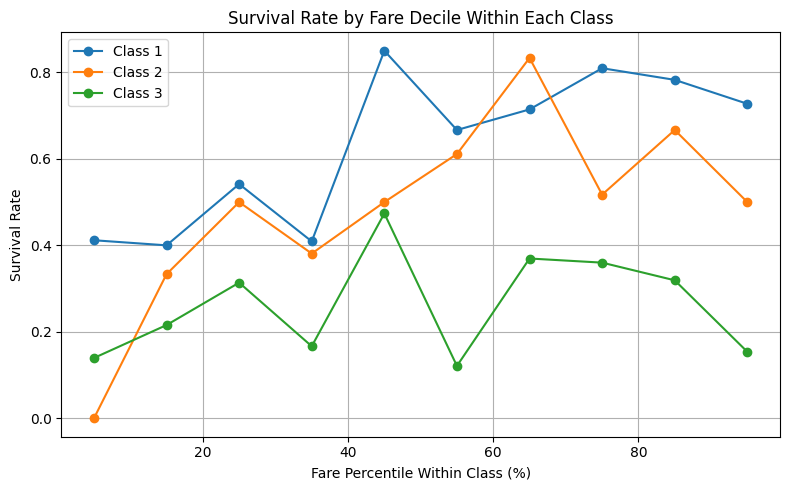

In [63]:
import numpy as np
import matplotlib.pyplot as plt
df = train.copy()
df['fare_pct'] = df.groupby('Pclass')['Fare'].rank(pct=True)
bins = np.linspace(0, 1, 11)
decile_labels = (bins[:-1] + bins[1:]) / 2  
df['decile'] = pd.cut(df['fare_pct'], bins=bins, labels=decile_labels, include_lowest=True)

surv_rates = (
    df.groupby(['Pclass', 'decile'])['Survived']
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,5))
for cls in [1, 2, 3]:
    sub = surv_rates[surv_rates['Pclass'] == cls]
    plt.plot(sub['decile'].astype(float) * 100, sub['Survived'], marker='o', label=f'Class {cls}')

plt.title('Survival Rate by Fare Decile Within Each Class')
plt.xlabel('Fare Percentile Within Class (%)')
plt.ylabel('Survival Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


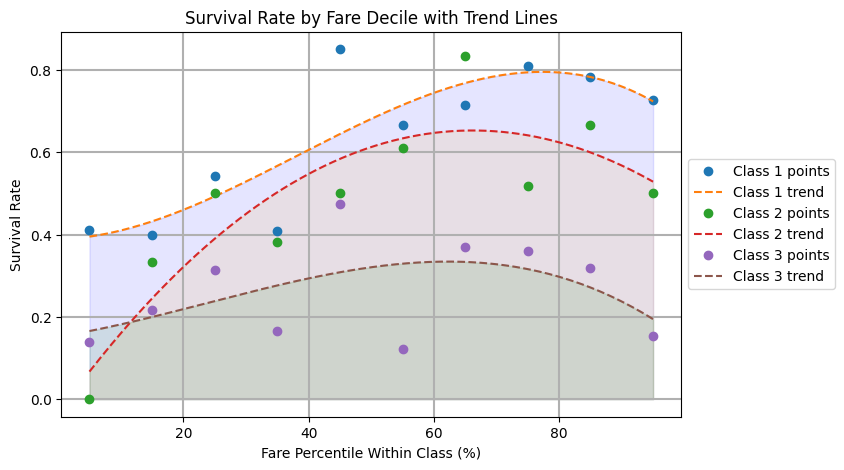

In [80]:
plt.figure(figsize=(8,5))
colors = {1: 'blue', 2: 'orange', 3: 'green'}
for cls in [1,2,3]:
    sub = surv_rates[surv_rates['Pclass']==cls]
    x = sub['decile'].astype(float)*100
    y = sub['Survived']
    # raw points
    plt.plot(x, y, 'o', label=f'Class {cls} points')
    
    # fit a 3rd-degree polynomial trend line
    coeffs = np.polyfit(x, y, deg=3)
    poly   = np.poly1d(coeffs)
    x_line = np.linspace(x.min(), x.max(), 200)
    plt.plot(x_line, poly(x_line), '--', label=f'Class {cls} trend')
    plt.fill_between(x_line, poly(x_line), alpha=0.1, color=colors[cls])

plt.xlabel('Fare Percentile Within Class (%)')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Fare Decile with Trend Lines')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linewidth=1.5)
plt.show()

In [74]:
help(plt.grid)


Help on function grid in module matplotlib.pyplot:

grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'
    Configure the grid lines.

    Parameters
    ----------
    visible : bool or None, optional
        Whether to show the grid lines.  If any *kwargs* are supplied, it
        is assumed you want the grid on and *visible* will be set to True.

        If *visible* is *None* and there are no *kwargs*, this toggles the
        visibility of the lines.

    which : {'major', 'minor', 'both'}, optional
        The grid lines to apply the changes on.

    axis : {'both', 'x', 'y'}, optional
        The axis to apply the changes on.

    **kwargs : `~matplotlib.lines.Line2D` properties
        Define the line properties of the grid, e.g.::

            grid(color='r', linestyle='-', linewidth=2)

        Valid keyword arguments are:

        Properties:
        agg_filter: a filter fun

   Pclass decile   n
0       1   0.05  17
1       1   0.15  25
2       1   0.25  24
3       1   0.35  22
4       1   0.45  20
5       1   0.55  21
6       1   0.65  21
7       1   0.75  21
8       1   0.85  23
9       1   0.95  22


C:\Users\MWOfficeDesktop\AppData\Local\Temp\ipykernel_42868\2733364103.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Pclass','decile'])


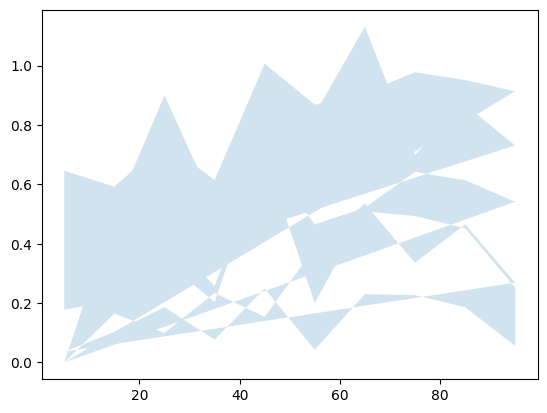

In [ ]:
counts = (
    df.groupby(['Pclass','decile'])
      .size()
      .reset_index(name='n')
)
print(counts.head(10))